In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv('../../data/HuBMAP-20-dataset_information.csv')

In [3]:
train_data

image_file  width_pixels  height_pixels  \
0   aa05346ff.tiff         47340          30720   
1   afa5e8098.tiff         43780          36800   
2   54f2eec69.tiff         22240          30440   
3   d488c759a.tiff         29020          46660   
4   1e2425f28.tiff         32220          26780   
5   e79de561c.tiff         27020          16180   
6   c68fe75ea.tiff         49780          26840   
7   095bf7a1f.tiff         39000          38160   
8   26dc41664.tiff         42360          38160   
9   57512b7f1.tiff         43160          33240   
10  4ef6695ce.tiff         50680          39960   
11  aaa6a05cc.tiff         13013          18484   
12  b9a3865fc.tiff         40429          31295   
13  cb2d976f4.tiff         49548          34940   
14  b2dc8411c.tiff         31262          14844   
15  2ec3f1bb9.tiff         47723          23990   
16  0486052bb.tiff         34937          25784   
17  3589adb90.tiff         22165          29433   
18  2f6ecfcdf.tiff         25794          31278   
19  8242609fa.tiff         44066          31299   

   anatomical_structures_segmention_file glomerulus_segmentation_file  \
0    aa05346ff-anatomical-structure.json               aa05346ff.json   
1    afa5e8098-anatomical-structure.json               afa5e8098.json   
2    54f2eec69-anatomical-structure.json               54f2eec69.json   
3    d488c759a-anatomical-structure.json               d488c759a.json   
4    1e2425f28-anatomical-structure.json               1e2425f28.json   
5    e79de561c-anatomical-structure.json               e79de561c.json   
6    c68fe75ea-anatomical-structure.json               c68fe75ea.json   
7    095bf7a1f-anatomical-structure.json               095bf7a1f.json   
8    26dc41664-anatomical-structure.json               26dc41664.json   
9    57512b7f1-anatomical-structure.json               57512b7f1.json   
10   4ef6695ce-anatomical-structure.json               4ef6695ce.json   
11   aaa6a05cc-anatomical-structure.json               aaa6a05cc.json   
12   b9a3865fc-anatomical-structure.json               b9a3865fc.json   
13   cb2d976f4-anatomical-structure.json               cb2d976f4.json   
14   b2dc8411c-anatomical-structure.json               b2dc8411c.json   
15   2ec3f1bb9-anatomical-structure.json               2ec3f1bb9.json   
16   0486052bb-anatomical-structure.json               0486052bb.json   
17   3589adb90-anatomical-structure.json               3589adb90.json   
18   2f6ecfcdf-anatomical-structure.json               2f6ecfcdf.json   
19   8242609fa-anatomical-structure.json               8242609fa.json   

    patient_number                       race               ethnicity     sex  \
0            67347                      White  Not Hispanic or Latino  Female   
1            67347                      White  Not Hispanic or Latino  Female   
2            67548  Black or African American  Not Hispanic or Latino    Male   
3            68138                      White  Not Hispanic or Latino  Female   
4            63921                      White  Not Hispanic or Latino    Male   
5            67026  Black or African American  Not Hispanic or Latino    Male   
6            67112                      White  Not Hispanic or Latino    Male   
7            68250                      White  Not Hispanic or Latino  Female   
8            68304                      White  Not Hispanic or Latino  Female   
9            68555                      White  Not Hispanic or Latino  Female   
10           66999                      White  Not Hispanic or Latino    Male   
11           65631                      White  Not Hispanic or Latino  Female   
12           67347                      White  Not Hispanic or Latino  Female   
13           67548  Black or African American  Not Hispanic or Latino    Male   
14           67026  Black or African American  Not Hispanic or Latino    Male   
15           67112                      White  Not Hispanic or Latino    Male   
16           67177       

In [4]:
pd.read_csv('../../data/train.csv')

id                                           encoding
0   2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
1   8242609fa  96909968 56 96941265 60 96972563 64 97003861 6...
2   aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
3   cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
4   b9a3865fc  61271840 4 61303134 13 61334428 22 61365722 30...
5   b2dc8411c  56157731 21 56172571 45 56187411 51 56202252 5...
6   0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
7   e79de561c  7334642 14 7350821 41 7367001 67 7383180 82 73...
8   095bf7a1f  113277795 21 113315936 53 113354083 87 1133922...
9   54f2eec69  124967057 36 124997425 109 125027828 147 12505...
10  4ef6695ce  137041956 58 137081912 65 137121869 72 1371618...
11  26dc41664  245832956 28 245869925 2 245871115 33 24590808...
12  c68fe75ea  21256809 3 21283644 10 21310479 17 21337315 22...
13  afa5e8098  65837968 7 65874765 11 65874827 12 65911562 15...
14  1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

## Quick Exploratory Data Analysis

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm

In [4]:
import rasterio
from rasterio.windows import Window
from torch.utils.data import Dataset
import zipfile

In [5]:
BASE_PATH = '../../data/train'
sz = 512
reduce = 2
MASK = '../../data/train.csv'
DATA = '../../data/train/'
OUT_TRAIN = '../../data/processed/train.zip'
OUT_MASK = '../../data/processed/mask.zip'
os.makedirs('../../data/processed/',exist_ok=True)

In [7]:
import pandas as pd
df_masks = pd.read_csv(MASK,index_col='id')

In [8]:
def enc2mask(mask_rle,shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width, height) of array to return 
    return: numpy array (width, height)
    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x,dtype=int) for x in (s[0:][::2],s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1],dtype=np.uint8)
    for lo,hi in zip(starts,ends):
        img[lo:hi]=1
    return img.reshape(shape).T

In [28]:
# data_train = pd.read_csv(MASK)
# for i in data_train.id:
#     rle2mask()
# directly read cannot be loaded into 16GB RAM 30000*40000
# use rasterio to load image part by part

s_th = 40 #saturation blank threshold
p_th = 1000*(sz//256)**2  #threshold for the minimum number of pixels
class HuBMAPDataset(Dataset):
    def __init__(self,idx,sz=sz,reduce=reduce,encs=None):
        self.data = rasterio.open(os.path.join(DATA,idx+'.tiff'))
        # issues with format
        if self.data.count!=3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets)>0:
                for i,subdataset in enumerate(subdatasets,0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape
        self.reduce = reduce
        self.sz = reduce*sz
        self.pad0 = (self.sz - self.shape[0]%self.sz)%self.sz
        self.pad1 = (self.sz - self.shape[1]%self.sz)%self.sz
        self.n0max = (self.shape[0]+self.pad0)//self.sz
        self.n1max = (self.shape[1]+self.pad1)//self.sz
        self.mask = enc2mask(encs,(self.shape[1],self.shape[0] if encs is not None else None))
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self,idx):
        # tiles created with adding padding
        # idx = n0*self.n1max + n1
        n0,n1 = idx//self.n1max, idx%self.n1max
        # x0,y0 are the coordinates of the lower left corner of the tile
        x0,y0 = -self.pad0//2+n0*self.sz, -self.pad1//2+n1*self.sz
        
        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])
        
        img = np.zeros((self.sz,self.sz,3),np.uint8)
        mask = np.zeros((self.sz,self.sz),np.uint8)
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)]=np.moveaxis(self.data.read([1,2,3],
                                        window=Window.from_slices((p00,p01),(p10,p11))),0,-1)
        else:
            # data.count=1, but got 3 subdatasets, -> 3 layers
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i]=layer.read(1,window = Window.from_slices((p00,p01),(p10,p11)))
        if self.mask is not None: mask[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = self.mask[p00:p01,p10:p11]
        if self.reduce != 1:
            img = cv2.resize(img,(self.sz//reduce,self.sz//reduce),interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask,(self.sz//reduce,self.sz//reduce),interpolation=cv2.INTER_NEAREST)
        
        #drop
        hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        return img,mask, x0,y0,(-1 if (s>s_th).sum()<=p_th or img.sum()<=p_th else idx)
            

In [ ]:
import numpy as np
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN,'w') as img_out,\
    zipfile.ZipFile(OUT_MASK,'w') as mask_out:
    for index,encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        ds = HuBMAPDataset(index,encs=encs['encoding'])
        for i in range(len(ds)):
            im,m,x0,y0,idx = ds[i]
            if idx<0: continue
            im = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
            os.makedirs(f'../../data/processed/train/{index}',exist_ok=True)
            cv2.imwrite(f'../../data/processed/train/{index}/{index}_{x0:05d}_{y0:05d}.png',im)
            cv2.imwrite(f'../../data/processed/train/{index}/{index}_{x0:05d}_{y0:05d}_mask.png',m)

            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            im = cv2.imencode('.png',im)[1]
            img_out.writestr(f'{index}_{x0:05d}_{y0:05d}.png',im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{x0:05d}_{y0:05d}.png',m)
                
# #image state
# img_avr = np.array(x_tot).mean(0)
# img_std = np.sqrt(np.array(x2_tot).mean(0)-img_avr**2)

  0%|          | 0/15 [00:00<?, ?it/s]/home/p303872/.local/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
 53%|█████▎    | 8/15 [25:43<18:54, 162.09s/it]

In [ ]:
for index,encs in tqdm(df_masks[8:].iterrows(),total=len(df_masks[8:])):
    ds = HuBMAPDataset(index,encs=encs['encoding'])
    for i in range(len(ds)):
        im,m,x0,y0,idx = ds[i]
        if idx<0: continue
        im = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
        os.makedirs(f'../../data/processed/train/{index}',exist_ok=True)
        cv2.imwrite(f'../../data/processed/train/{index}/{index}_{x0:05d}_{y0:05d}.png',im)
        cv2.imwrite(f'../../data/processed/train/{index}/{index}_{x0:05d}_{y0:05d}_mask.png',m)


 57%|█████▋    | 4/7 [12:33<10:00, 200.08s/it]

In [21]:
data = rasterio.open(os.path.join(DATA,'1e2425f28'+'.tiff'))
data

In [26]:
data.shape

(26780, 32220)

In [23]:
data.subdatasets
layers = []
if len(data.subdatasets)>0:
    for i,subdataset in enumerate(data.subdatasets,0):
        layers.append(rasterio.open(subdataset))

In [24]:
layers

[<open DatasetReader name='GTIFF_DIR:1:../../data/train/1e2425f28.tiff' mode='r'>,
 <open DatasetReader name='GTIFF_DIR:2:../../data/train/1e2425f28.tiff' mode='r'>,
 <open DatasetReader name='GTIFF_DIR:3:../../data/train/1e2425f28.tiff' mode='r'>]

In [27]:
pad0 = (1024 - data.shape[0]%1024)%1024
pad1 = (1024 - data.shape[1]%1024)%1024
n0max = (data.shape[0]+pad0)//sz
n1max = (data.shape[1]+pad1)//sz
# print(pad0,pad1,n0max,n1max) #868 548 54 64

n0,n1 = 0,1
# x0,y0 are the coordinates of the lower left corner of the tile
x0,y0 = -pad0//2+n0*1024, -pad1//2+n1*1024

p00,p01 = max(0,x0), min(x0+1024,data.shape[0])
p10,p11 = max(0,y0), min(y0+1024,data.shape[1])

img = np.zeros((1024,1024,3),np.uint8)
mask = np.zeros((1024,1024),np.uint8)
for i,layer in enumerate(layers):
    img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i]=layer.read(1,window = Window.from_slices((p00,p01),(p10,11)))
if self.mask is not None: mask[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = self.mask[p00:p01,p10:p11]


868 548 54 64


In [12]:
#8,#10,#11,#12 #14
df_masks[7:]

encoding
id                                                          
e79de561c  7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f  113277795 21 113315936 53 113354083 87 1133922...
54f2eec69  124967057 36 124997425 109 125027828 147 12505...
4ef6695ce  137041956 58 137081912 65 137121869 72 1371618...
26dc41664  245832956 28 245869925 2 245871115 33 24590808...
c68fe75ea  21256809 3 21283644 10 21310479 17 21337315 22...
afa5e8098  65837968 7 65874765 11 65874827 12 65911562 15...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [46]:
columns,rows = 4,4
idx0=20
fig = plt.figure(figszie=(columns*4,rows*4))
with zipfile.ZipFile(OUT_TRAIN,'r') as img_arch, zipfile.ZipFile(OUT_MASK,'r') as mask_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.decode(np.frombuffer(img_arch.read))

806

In [23]:
len(df_masks)

15

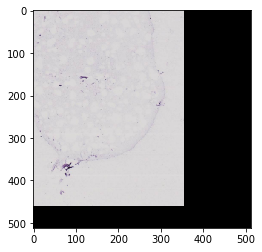

In [77]:
plt.imshow(im)


Populating the interactive namespace from numpy and matplotlib


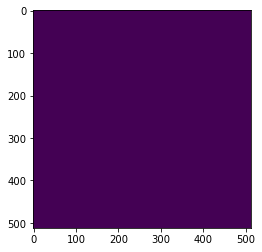

In [76]:
%pylab inline
plt.imshow(m)


[array([0.84141756, 0.81328698, 0.8541204 ]),
 array([0.84141756, 0.81328698, 0.8541204 ]),
 array([0.84141756, 0.81328698, 0.8541204 ]),
 array([0.84605037, 0.81827761, 0.85726092]),
 array([0.696626  , 0.59013097, 0.75646126]),
 array([0.61640462, 0.46197392, 0.70333478])]

In [67]:
y0

11873

In [68]:
idx

64

In [69]:
len(ds)

806

In [4]:
import glob
import os
train_path = sorted(os.listdir('../../data/processed/train/'))[:50]
mask_path = sorted(os.listdir('../../data/processed/mask/'))[:50]


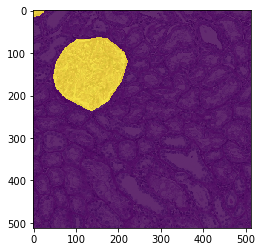

In [39]:
img = Image.open('../../data/processed/train/'+train_path[23])
msk = Image.open('../../data/processed/mask/'+train_path[23])

plt.imshow(img)
plt.imshow(msk,alpha=0.8)

Populating the interactive namespace from numpy and matplotlib


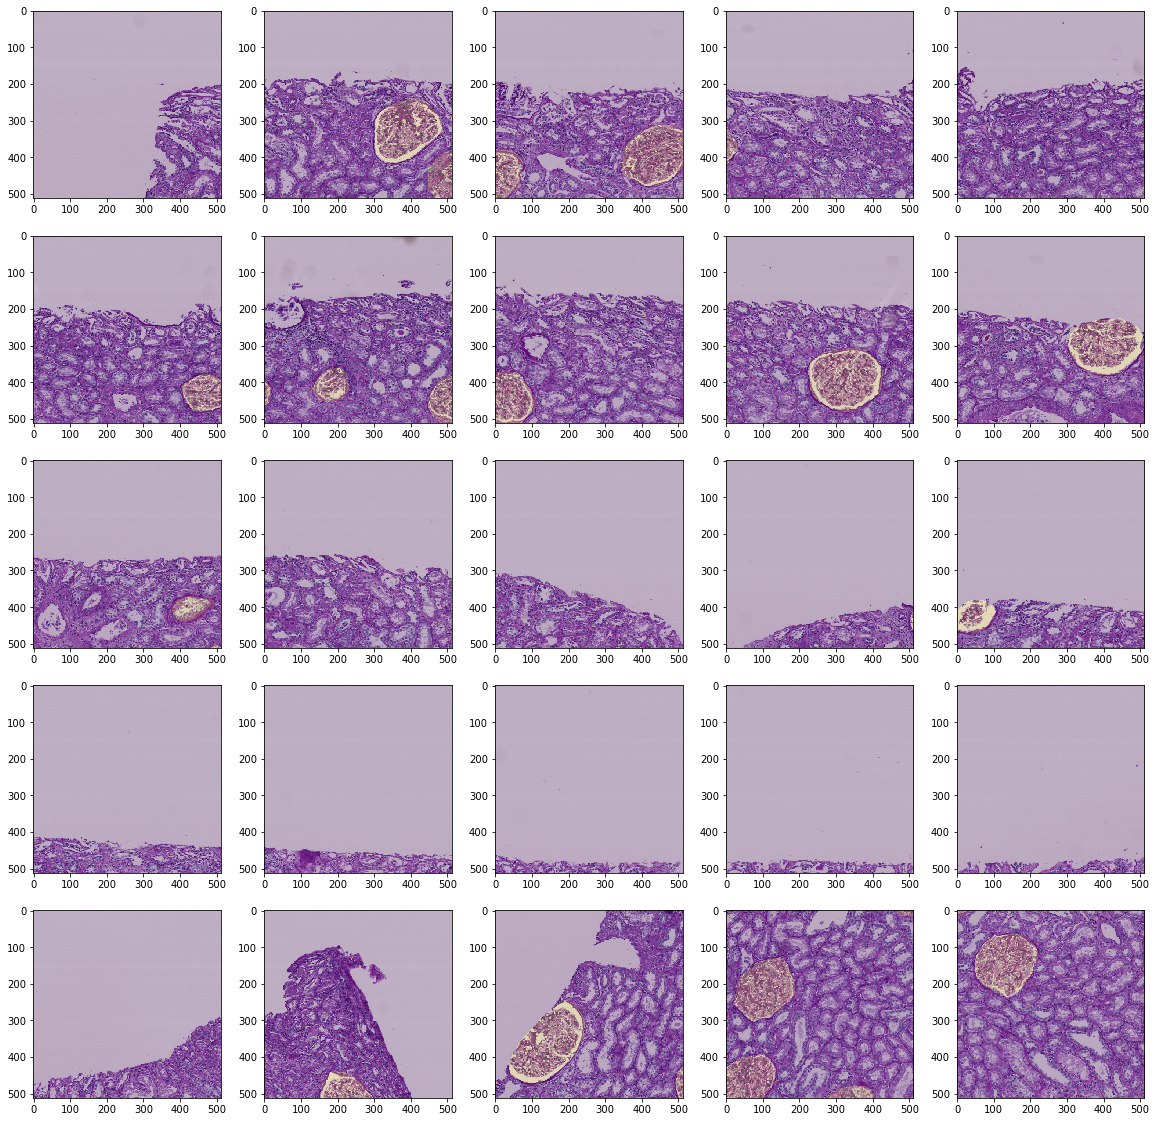

In [40]:
from PIL import Image
%pylab inline
rows,cols = 5,5
fig,ax = plt.subplots(rows,cols,figsize=(4*rows,4*cols))
for i in range(rows):
    for j in range(cols):
        img = Image.open('../../data/processed/train/'+train_path[i*cols+j])
        msk = Image.open('../../data/processed/mask/'+train_path[i*cols+j])
        
        ax[i,j].imshow(img)
        ax[i,j].imshow(msk.convert('L'),alpha=0.1)
        


Populating the interactive namespace from numpy and matplotlib


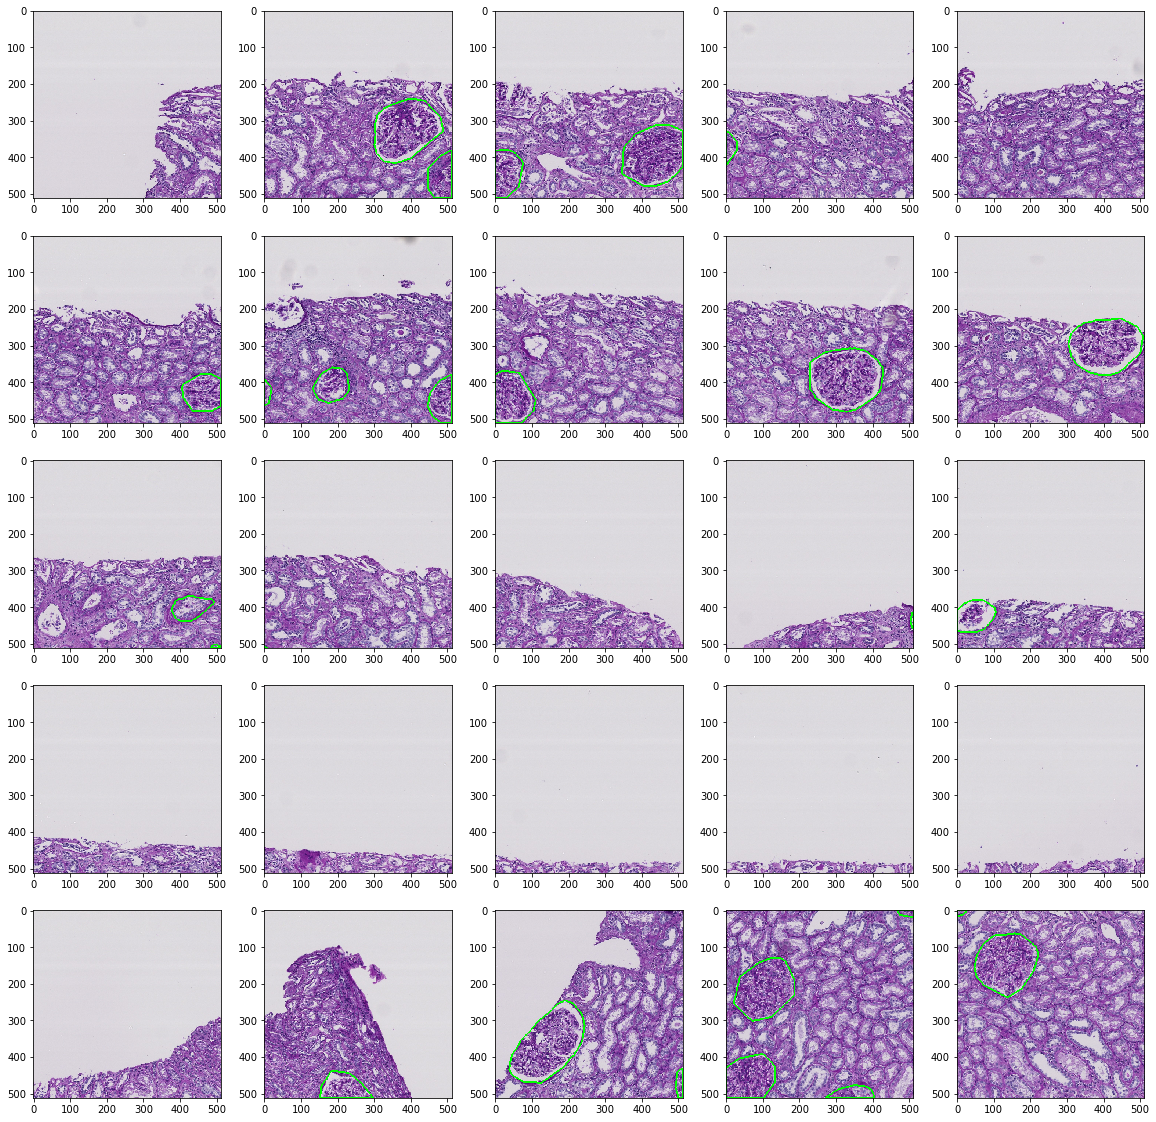

In [108]:
from PIL import Image
%pylab inline
rows,cols = 5,5
fig,ax = plt.subplots(rows,cols,figsize=(4*rows,4*cols))
for i in range(rows):
    for j in range(cols):
        msk = cv2.imread('../../data/processed/mask/'+train_path[i*cols+j],0)
        img = cv2.imread('../../data/processed/train/'+train_path[i*cols+j],1)

        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        contours,_ = cv2.findContours(msk,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        img2= cv2.drawContours(img,contours,-1,(0,255,0),3)
        
        ax[i,j].imshow(img2)
        


In [19]:
from PIL import Image
?Image.open

In [5]:
import cv2
msk = cv2.imread('../../data/processed/mask/'+train_path[23],0)
img = cv2.imread('../../data/processed/train/'+train_path[23],1)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# ret, thresh = cv2.threshold(msk, 127, 127, 127)
im2,contours = cv2.findContours(msk,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img2= cv2.drawContours(img,im2,-1,(0,255,0),3)

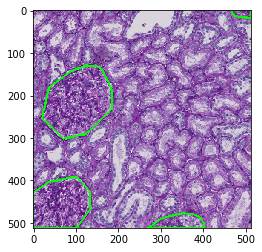

In [107]:
plt.imshow(img2)

In [72]:
?cv2.drawContours

In [6]:
img

array([[[141, 106, 169],
        [177, 130, 189],
        [128,  73, 153],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[177, 137, 206],
        [179, 125, 192],
        [132,  72, 159],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[ 81,  39, 127],
        [ 99,  56, 136],
        [114,  56, 153],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [178, 139, 196],
        [176, 130, 192],
        [157, 108, 173]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [169, 131, 189],
        [185, 140, 202],
        [174, 124, 190]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [160, 126, 187],
        [168, 126, 192],
        [174, 126, 194]]

In [12]:
from PIL import Image
import numpy as np
np.array(Image.open('../../data/processed/mask/'+train_path[23])).shape


(512, 512)

In [11]:
msk

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [13]:
cv2.imread('../../data/processed/mask/'+train_path[23]).shape


(512, 512, 3)

In [ ]:
# save processed information ['file_name','image_name','patient_number','num_masked_pixels','ratio_masked_area','std_img']
import os,cv2
import pandas as pd
from tqdm import tqdm
import glob
masks_path = glob.glob('../../data/processed/train/*/*mask.png')
train_data = pd.read_csv('../../data/HuBMAP-20-dataset_information.csv')
data_info = pd.DataFrame(columns=['filename','image_name','patient_number','num_masked_pixels','ratio_masked_area','std_img'])
for path in tqdm(masks_path):
    msk = cv2.imread(path,0)
    img_dir = os.path.split(path)[0]
    img_name = path.split('/')[-1].split('_mask')[0]
    img = cv2.imread(img_dir+'/'+ img_name+'.png',1)
    image_name = img_name.split('_')[0]
    num_masked_pixels = msk.sum()
    ratio_masked_area = num_masked_pixels/(msk.shape[0]*msk.shape[1])
    std_img = img.std()
    patient_number = train_data[train_data['image_file']==image_name+'.tiff']['patient_number'].values[0]
    data_info=data_info.append({'filename':img_name,'image_name':image_name,'patient_number':patient_number,'num_masked_pixels':num_masked_pixels,'ratio_masked_area':ratio_masked_area,
                     'std_img':std_img},ignore_index=True)
#     break
data_info.to_csv('../../data/processed/train_info.csv')

  1%|▏         | 128/9584 [00:13<13:23, 11.77it/s]

In [22]:
data_info

filename image_name patient_number num_masked_pixels  \
0  4ef6695ce_26124_35580  4ef6695ce          66999             41775   

   ratio_masked_area    std_img  
0           0.159359  46.131356

In [17]:
train_data[train_data['image_file']==image_name]['patient_number'].values[0]

66999

In [16]:
train_data[train_data['image_file']==image_name]['patient_number']

10    66999
Name: patient_number, dtype: int64

In [10]:
path.split('_')[0]

'2f6ecfcdf'

In [14]:
data_info.image_name.unique()

array(['cb2d976f4', '8242609fa', '2f6ecfcdf', 'b9a3865fc', '0486052bb',
       'b2dc8411c', 'e79de561c', 'aaa6a05cc'], dtype=object)

In [ ]:
def get_fold_idxs_list(data_df,val_patient_numbers_list):
    trn_idxs_list=[]
    val_idx_list = []
    for fold in range(len(val_patient_numbers_list)):
        trn_idxs = data_df[~data_df['patient_number'].isin(val_patient_numbers_list[fold])].index.tolist()
        trn_idxs_list.append(np.array(trn_idxs))
        val_idxs = data_df[data_df['patient_number'].isin(val_patient_numbers_list[fold])].index.tolist()   
        val_idx_list.append(np.array(val_idxs))
    return trn_idxs_list,val_idx_list

In [16]:
len(os.listdir('../../data/processed/train/'))


3765

In [2]:
import numpy as np